### Extracting Monthly Temperature Data from Array
<b>Author: Ryan Gan</b>

<b>Date: 2018-05-28</b>

Extracting gridded temperature values to North American region. First attempt with Python.

In [1]:
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
from netCDF4 import Dataset as nc_open
# import numpy as np; for working with array data
import numpy as np
# import pandas as pd; working with data.frames
import pandas as pd
# Matplotlib for additional customization
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Open connection to NDVI.

In [4]:
ndvi_nc = nc_open("./data/AVHRR-Land_v004_AVH13C1_NOAA-07_19810624_c20130815112445.nc")

Print out summary stats.

In [5]:
print(ndvi_nc)
# print out details of each variable
for v in ndvi_nc.variables:
    print(ndvi_nc.variables[v])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Normalized Difference Vegetation Index parameters derived from NOAA-07 GAC data for day 1981/175
    institution: NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-LAND > MODIS Land Science Team, Terrestrial Information Systems,  Hydrospheric and Biospheric Science Laboratory, Earth Sciences Division, Science and Exploration Directorate, Goddard Space Flight Center, NASA
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v25, 05 July 2013)
    naming_authority: gov.noaa.ncdc
    license: No constraints on data access or use
    cdm_data_type: Grid
    time_coverage_start: 1981-06-24T00:00:00Z
    time_coverage_end: 1981-06-24T23:59:00Z
    product_version: v4r0
    platform: NOAA-4 > National Oceanic & Atmospheric Administration-4
    sensor: AVHRR > Advanced Very High Resolution Radiometer
    keywords_vocabulary: N

Extract variables.

In [11]:
# extract latitude
lat = ndvi_nc.variables['latitude'][:]
# extract longitude
lon = ndvi_nc.variables['longitude'][:]
# extract time
time = ndvi_nc.variables['time'][:]
# 1st temperature values
ndvi = ndvi_nc.variables['NDVI'][0,:,:]
# check dimension of shape
np.shape(ndvi)

(3600, 7200)

Print out min, mean, and max.

In [12]:
print(np.min(ndvi), np.mean(ndvi), np.max(ndvi))

-0.1 0.16735139135462823 0.9211


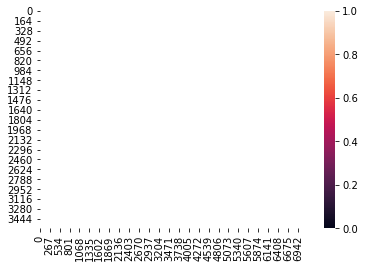

In [15]:
sns.heatmap(ndvi, vmin = -0.1, vmax = 0.95)

Subset array to bounding box of the US.

In [19]:
np.min(lon), np.max(lon)

(-180.0, 179.96277)

In [20]:
# lat and lon bounds
latbounds = [24.4, 49.4]
# lon bounds need to be converted from easterling to westerling to get US
lonbounds = [-124.8, -66.9]

# latitude lower and upper bounds
lat_ui = np.argmin(np.abs(lat - latbounds[0]))
lat_li = np.argmin(np.abs(lat - latbounds[1]))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(lon - lonbounds[0]))
lon_ui = np.argmin(np.abs(lon - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

812 1312 1104 2262


Subset US NDVI.

In [21]:
# subset us lon
lon_us = lon[lon_li:lon_ui]-360
# subset us lat
lat_us = lat[lat_li:lat_ui]
# print dimensions
print(np.min(lon_us), np.max(lon_us), np.min(lat_us), np.max(lat_us))

-484.79663 -426.9431 24.44902 49.39864


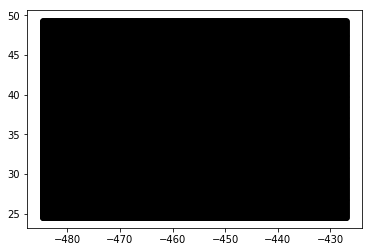

In [22]:
# extract lonlat grid
lons, lats = np.meshgrid(lon_us, lat_us)
# plot
plt.plot(lons, lats, marker='.', color='k', linestyle='none')
plt.show()

In [24]:
# subset ndvi to us
ndvi_us = ndvi_nc.variables['NDVI'][0, lat_li:lat_ui, lon_li:lon_ui]
np.shape(ndvi_us)

(500, 1158)

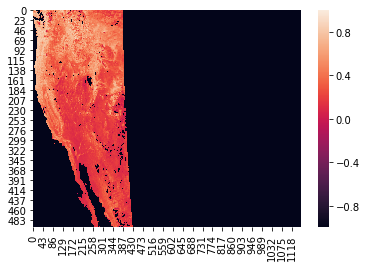

In [26]:
sns.heatmap(ndvi_us, vmin = -1, vmax=1)

Note I suspect a lot of the US is flagged because of when this data was collected (i.e. night-time on the east coast).